In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [2]:
file_path = "events.csv"
df = pd.read_csv("events.csv")

# Display dataset overview
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52966 entries, 0 to 52965
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Start time UTC                      52966 non-null  object 
 1   End time UTC                        52966 non-null  object 
 2   Start time UTC+03:00                52966 non-null  object 
 3   End time UTC+03:00                  52966 non-null  object 
 4   Electricity consumption in Finland  52966 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.0+ MB
None
        Start time UTC         End time UTC Start time UTC+03:00  \
0  2015-12-31 21:00:00  2015-12-31 22:00:00  2016-01-01 00:00:00   
1  2015-12-31 22:00:00  2015-12-31 23:00:00  2016-01-01 01:00:00   
2  2015-12-31 23:00:00  2016-01-01 00:00:00  2016-01-01 02:00:00   
3  2016-01-01 00:00:00  2016-01-01 01:00:00  2016-01-01 03:00:00   
4  2016-01-01 01:00:00  2016-01-01 02:00

In [3]:
# Convert 'Start time UTC' to datetime and set as index
df['Start time UTC'] = pd.to_datetime(df['Start time UTC'])
df.set_index('Start time UTC', inplace=True)

# Interpolate missing values and remove duplicates
df.interpolate(method='linear', inplace=True)
df = df[~df.index.duplicated(keep='first')]

/var/folders/4q/tppj85sn47b0s1vxvzn76k700000gn/T/ipykernel_51685/2920259961.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [4]:
# Extract time-based features
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday  # 0=Monday, 6=Sunday

# Define seasons in Finland
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Autumn

df['Season'] = df['Month'].apply(get_season)

# Add lag features (previous consumption values)
df['Lag_1'] = df['Electricity consumption in Finland'].shift(1)
df['Lag_24'] = df['Electricity consumption in Finland'].shift(24)

# Fill missing values from shifting
df.fillna(method='bfill', inplace=True)

# Keep final features
features = ['Electricity consumption in Finland', 'Hour', 'Day', 'Month', 'Weekday', 'Season', 'Lag_1', 'Lag_24']
df = df[features]

print(df.head())

                     Electricity consumption in Finland  Hour  Day  Month  \
Start time UTC                                                              
2015-12-31 21:00:00                             10800.0    21   31     12   
2015-12-31 22:00:00                             10431.0    22   31     12   
2015-12-31 23:00:00                             10005.0    23   31     12   
2016-01-01 00:00:00                              9722.0     0    1      1   
2016-01-01 01:00:00                              9599.0     1    1      1   

                     Weekday  Season    Lag_1   Lag_24  
Start time UTC                                          
2015-12-31 21:00:00        3       0  10800.0  10800.0  
2015-12-31 22:00:00        3       0  10800.0  10800.0  
2015-12-31 23:00:00        3       0  10431.0  10800.0  
2016-01-01 00:00:00        4       0  10005.0  10800.0  
2016-01-01 01:00:00        4       0   9722.0  10800.0  


/var/folders/4q/tppj85sn47b0s1vxvzn76k700000gn/T/ipykernel_51685/3198193376.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


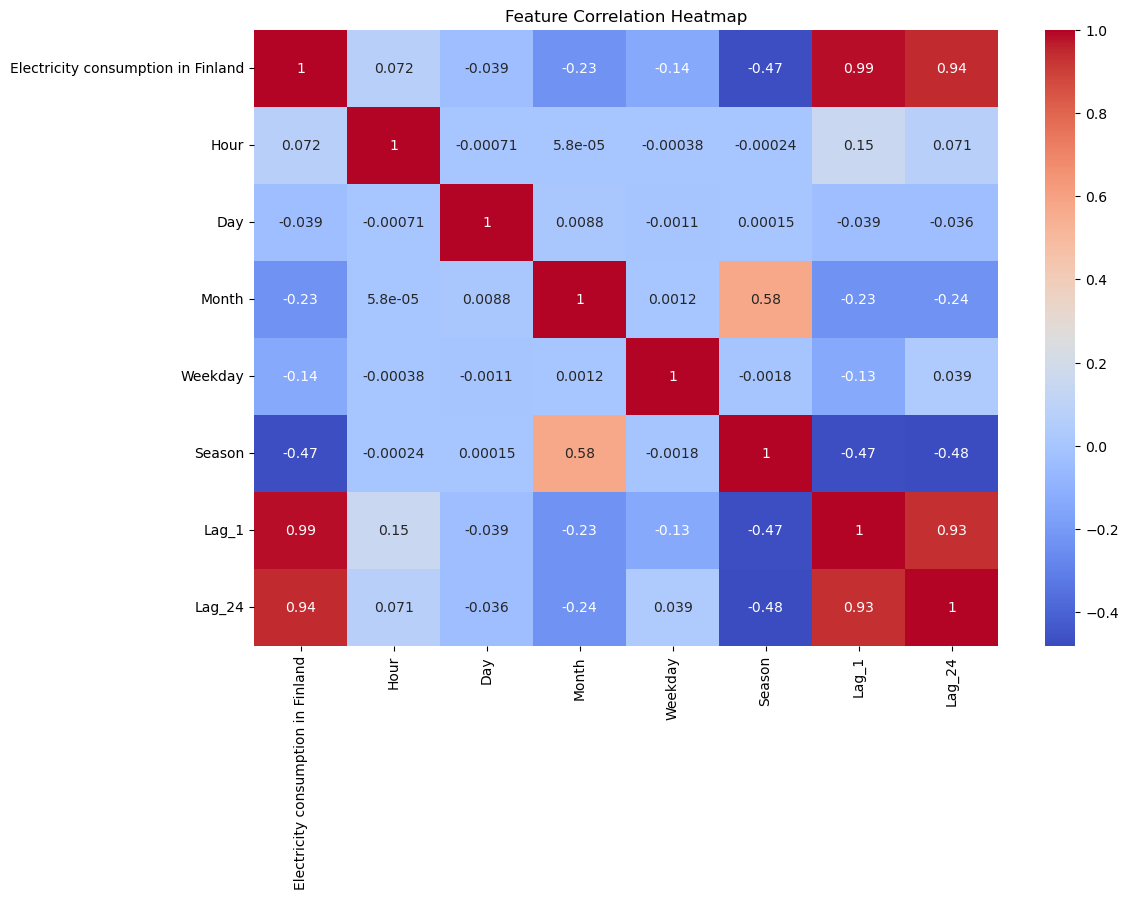

In [5]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [7]:
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step)])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [8]:
model = Sequential()

# Bidirectional LSTM for better feature extraction
model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=(time_step, X_train.shape[2]))))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=25, verbose=1, validation_data=(X_test, y_test))

Epoch 1/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 77s 113ms/step - loss: 0.0078 - val_loss: 0.0022
Epoch 2/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 3/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 81s 123ms/step - loss: 8.1492e-04 - val_loss: 0.0012
Epoch 4/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 94s 143ms/step - loss: 6.1412e-04 - val_loss: 8.0434e-04
Epoch 5/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 98s 148ms/step - loss: 5.1242e-04 - val_loss: 8.8332e-04
Epoch 6/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 92s 138ms/step - loss: 4.8255e-04 - val_loss: 3.5286e-04
Epoch 7/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 85s 128ms/step - loss: 4.6363e-04 - val_loss: 0.0011
Epoch 8/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 81s 122ms/step - loss: 3.8424e-04 - val_loss: 0.0010
Epoch 9/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 80s 121ms/step - loss: 3.9140e-04 - val_loss: 9.9070e-04
Epoch 10/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 81s 122ms/step - loss: 3.6119e-04 - val_loss: 0.0014
Epoch 11/25
662/662 ━━━━━━━━━━━━━━━━━━━━ 84s 127ms/step - los

In [ ]:
# Predict on train and test sets
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scale predictions
train_predict = scaler.inverse_transform(
    np.concatenate((train_predict, np.zeros((train_predict.shape[0], df.shape[1] - 1))), axis=1)
)[:, 0]

y_train_actual = scaler.inverse_transform(
    np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], df.shape[1] - 1))), axis=1)
)[:, 0]

test_predict = scaler.inverse_transform(
    np.concatenate((test_predict, np.zeros((test_predict.shape[0], df.shape[1] - 1))), axis=1)
)[:, 0]

y_test_actual = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], df.shape[1] - 1))), axis=1)
)[:, 0]

1323/1323 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step
330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


In [ ]:
# Compute metrics
train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predict))
train_mae = mean_absolute_error(y_train_actual, train_predict)
train_r2 = r2_score(y_train_actual, train_predict)

test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_predict))
test_mae = mean_absolute_error(y_test_actual, test_predict)
test_r2 = r2_score(y_test_actual, test_predict)

print(f"Train RMSE: {train_rmse:.2f}, Train MAE: {train_mae:.2f}, Train R²: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, Test MAE: {test_mae:.2f},   `Test R²: {test_r2:.2f}")

Train RMSE: 425.54, Train MAE: 332.05, Train R²: 0.93
Test RMSE: 458.64, Test MAE: 365.62,   `Test R²: 0.91


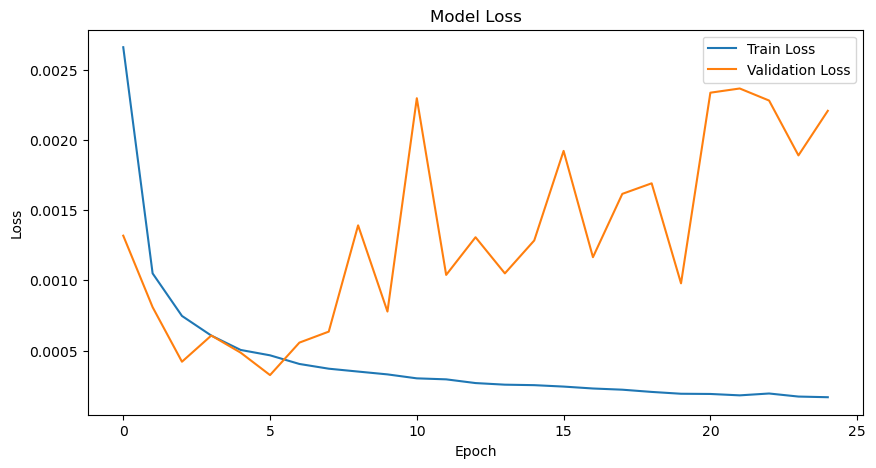

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

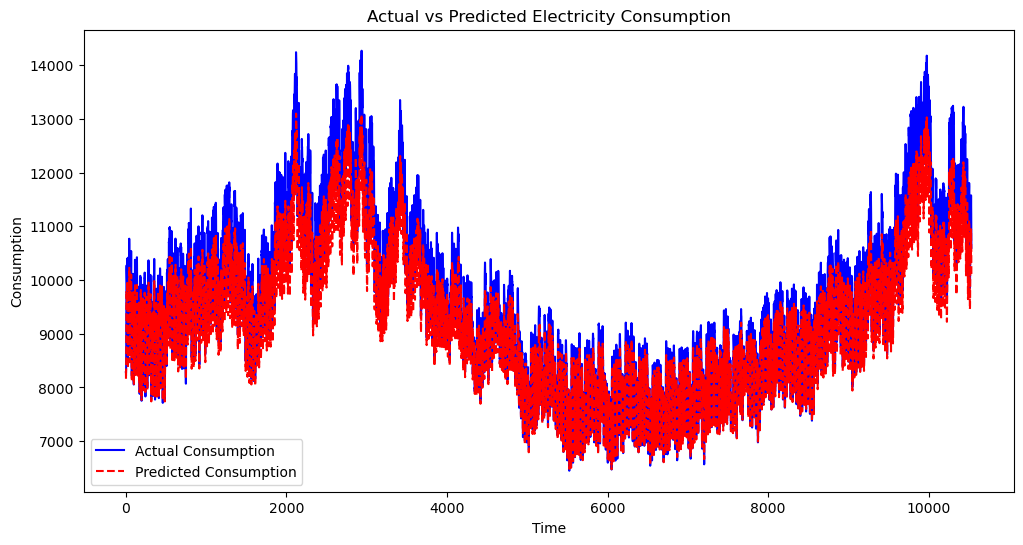

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Consumption", color="blue")
plt.plot(test_predict, label="Predicted Consumption", color="red", linestyle="dashed")
plt.title("Actual vs Predicted Electricity Consumption")
plt.xlabel("Time")
plt.ylabel("Consumption")
plt.legend()
plt.show()

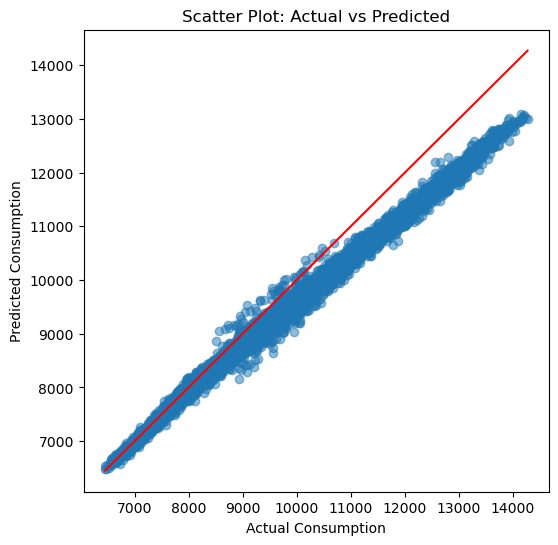

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_actual, test_predict, alpha=0.5)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color="red")
plt.xlabel("Actual Consumption")
plt.ylabel("Predicted Consumption")
plt.title("Scatter Plot: Actual vs Predicted")
plt.show()

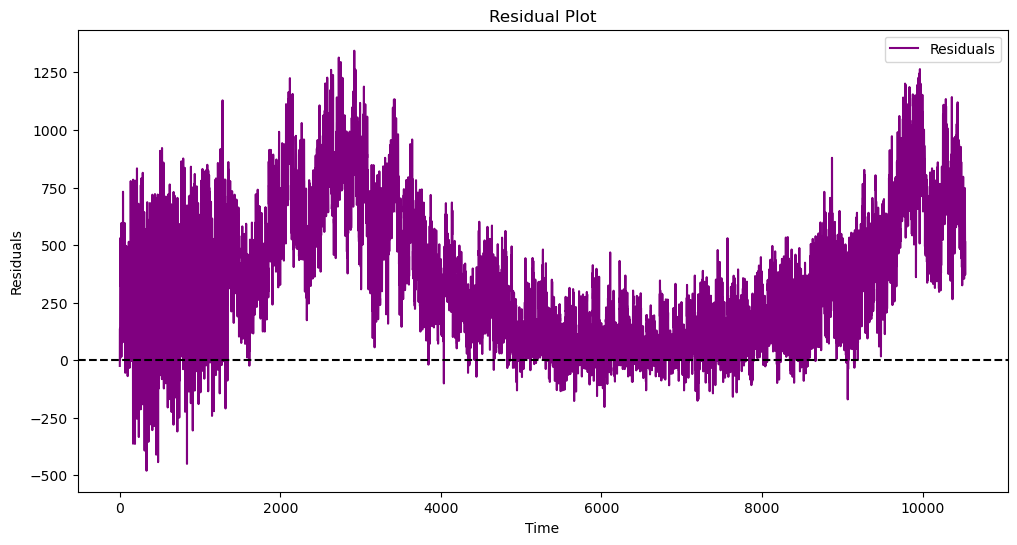

In [ ]:
residuals = y_test_actual - test_predict
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals", color="purple")
plt.axhline(y=0, color="black", linestyle="dashed")
plt.title("Residual Plot")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.show()

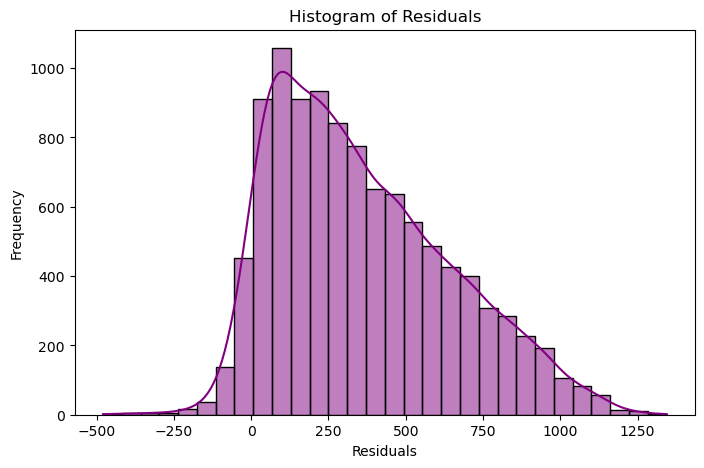

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color="purple")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

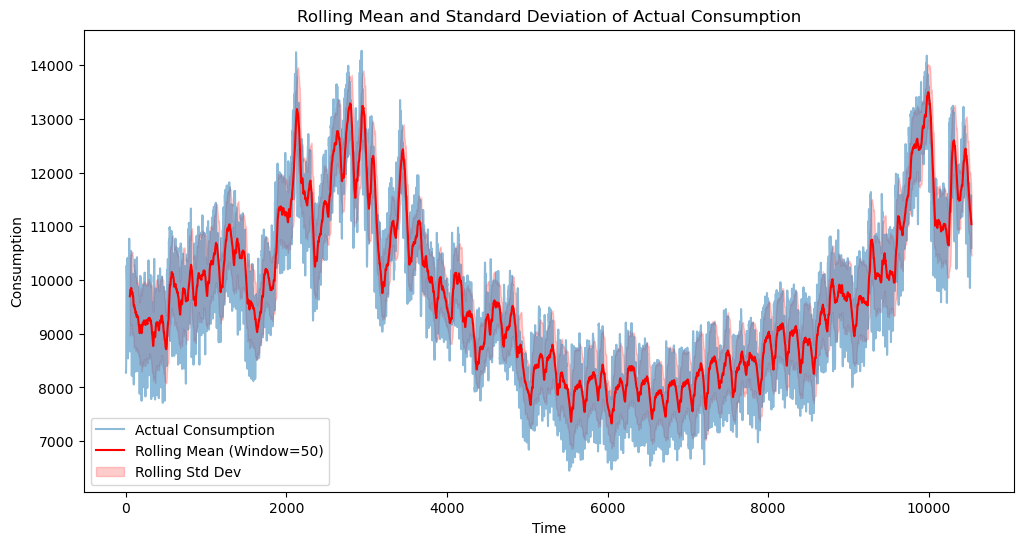

In [ ]:
window_size = 50  # Adjust as needed
rolling_mean = pd.Series(y_test_actual).rolling(window=window_size).mean()
rolling_std = pd.Series(y_test_actual).rolling(window=window_size).std()

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual Consumption", alpha=0.5)
plt.plot(rolling_mean, label=f"Rolling Mean (Window={window_size})", color="red")
plt.fill_between(range(len(y_test_actual)), rolling_mean - rolling_std, rolling_mean + rolling_std, 
                 color="red", alpha=0.2, label="Rolling Std Dev")
plt.title("Rolling Mean and Standard Deviation of Actual Consumption")
plt.xlabel("Time")
plt.ylabel("Consumption")
plt.legend()
plt.show()

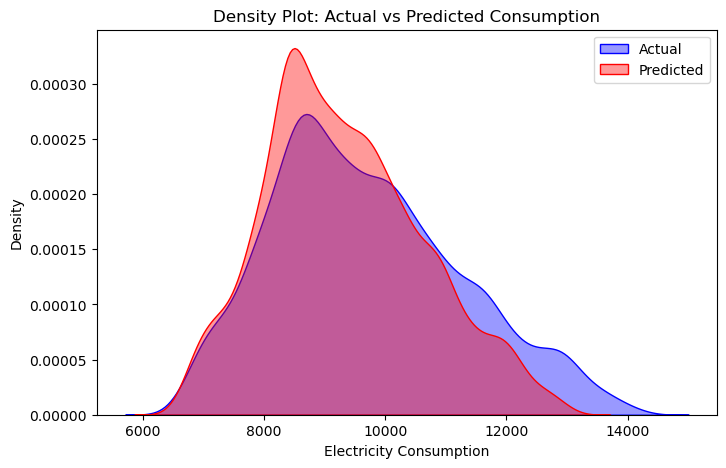

In [ ]:
plt.figure(figsize=(8, 5))
sns.kdeplot(y_test_actual, label="Actual", color="blue", fill=True, alpha=0.4)
sns.kdeplot(test_predict, label="Predicted", color="red", fill=True, alpha=0.4)
plt.title("Density Plot: Actual vs Predicted Consumption")
plt.xlabel("Electricity Consumption")
plt.ylabel("Density")
plt.legend()
plt.show()

<Figure size 1000x500 with 0 Axes>

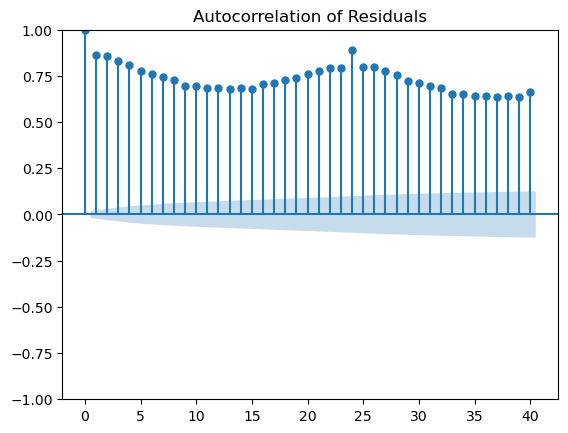

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=40)
plt.title("Autocorrelation of Residuals")
plt.show()

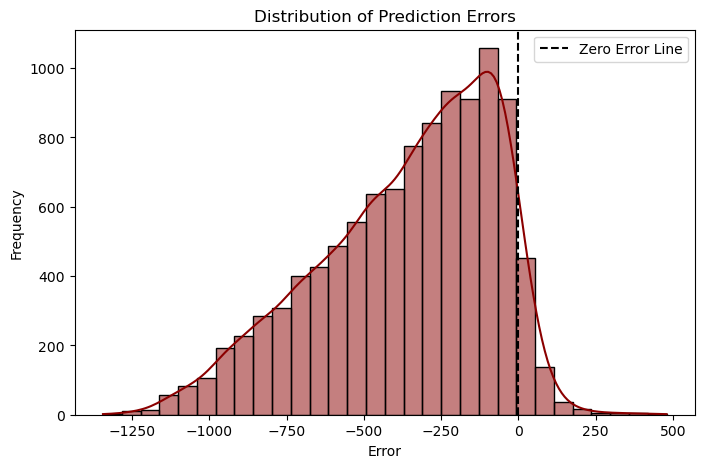

In [ ]:
error = test_predict - y_test_actual

plt.figure(figsize=(8, 5))
sns.histplot(error, bins=30, kde=True, color="darkred")
plt.axvline(x=0, color="black", linestyle="dashed", label="Zero Error Line")
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

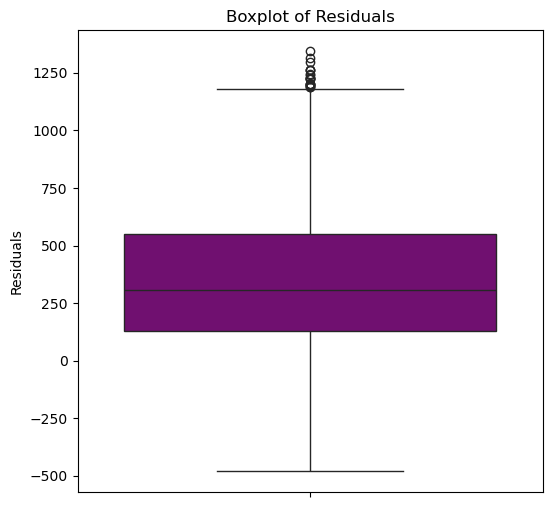

In [ ]:
plt.figure(figsize=(6, 6))
sns.boxplot(y=residuals, color="purple")
plt.title("Boxplot of Residuals")
plt.ylabel("Residuals")
plt.show()

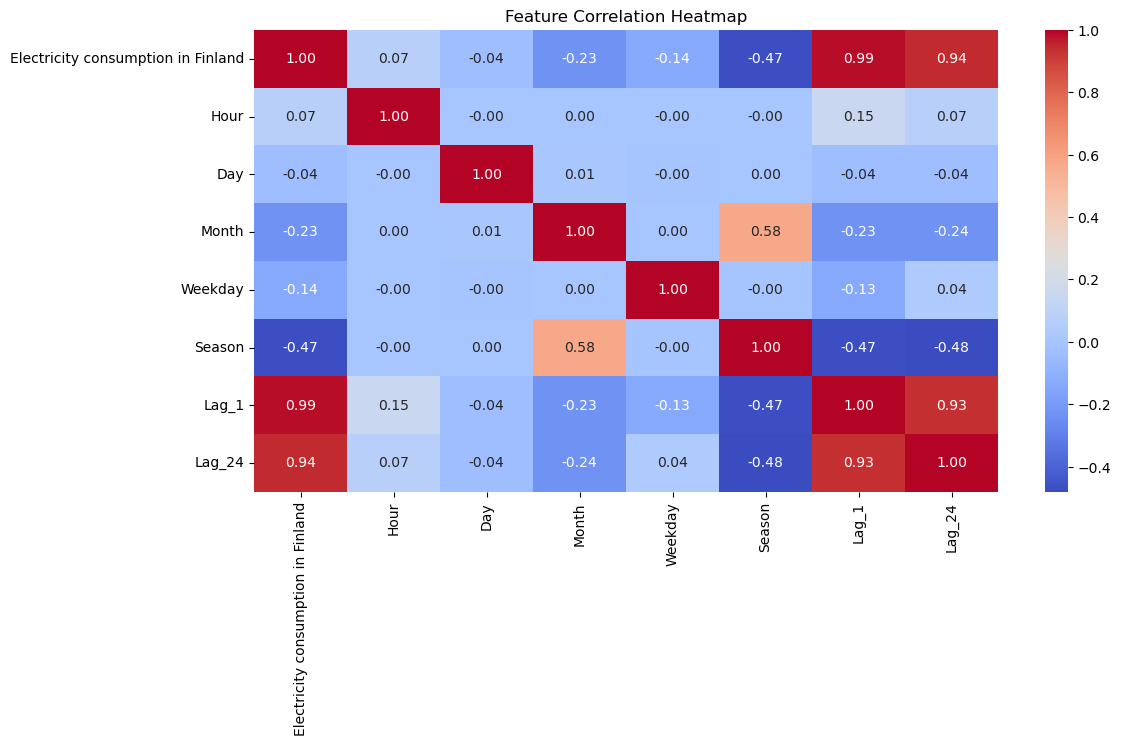

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

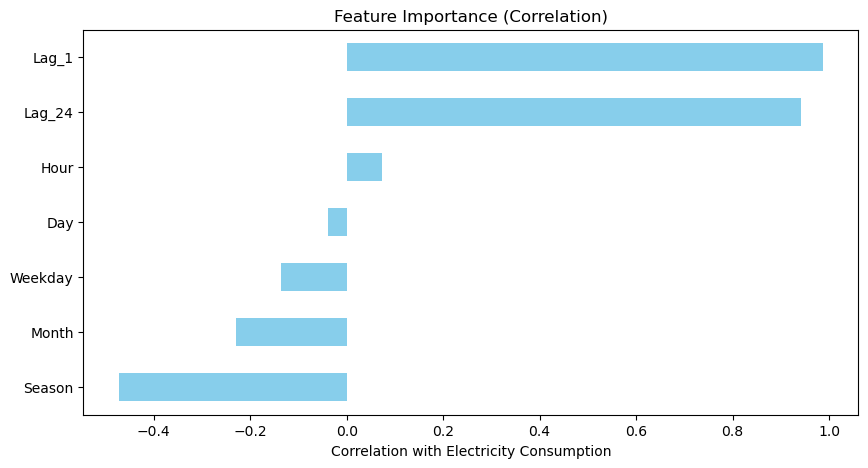

In [ ]:
# Compute correlation of each feature with target variable
feature_importance = df.corr()['Electricity consumption in Finland'].drop('Electricity consumption in Finland')

# Plot feature importance
plt.figure(figsize=(10, 5))
feature_importance.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel("Correlation with Electricity Consumption")
plt.title("Feature Importance (Correlation)")
plt.show()

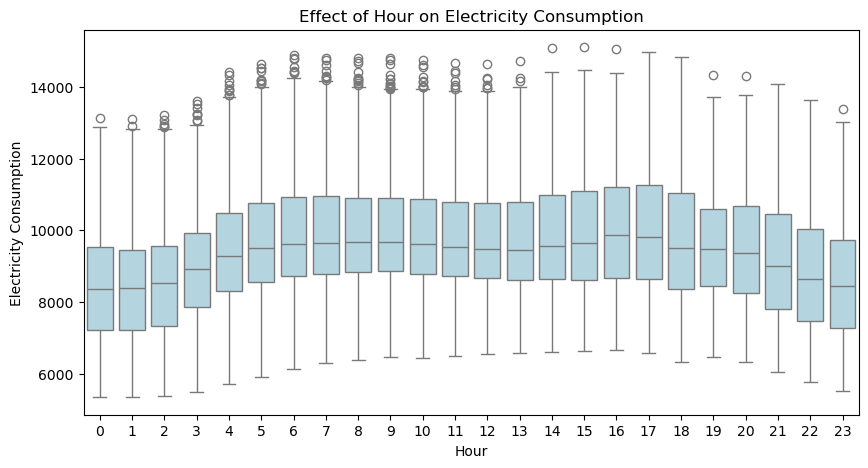

In [ ]:
import seaborn as sns

# Select a feature to analyze (e.g., Hour)
feature = "Hour"

# Plot actual vs. predicted values across different hours
plt.figure(figsize=(10, 5))
sns.boxplot(x=df[feature], y=df["Electricity consumption in Finland"], color="lightblue")
plt.xlabel(feature)
plt.ylabel("Electricity Consumption")
plt.title(f"Effect of {feature} on Electricity Consumption")
plt.show()

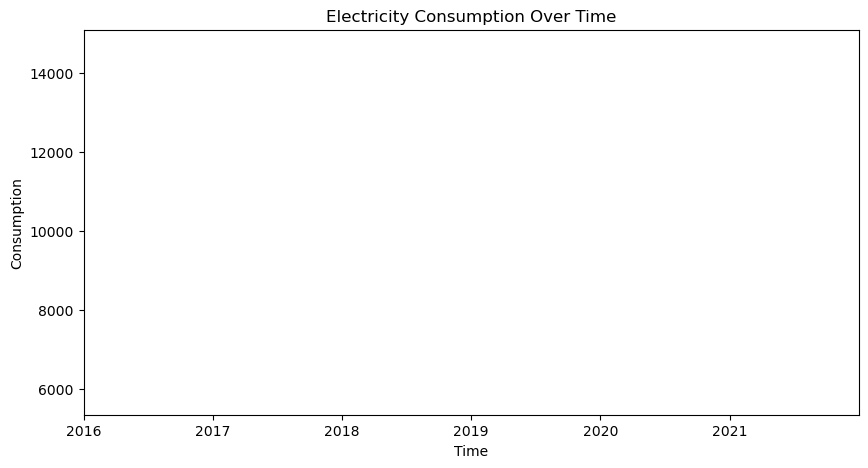

In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(df.index.min(), df.index.max())
ax.set_ylim(df["Electricity consumption in Finland"].min(), df["Electricity consumption in Finland"].max())
line, = ax.plot([], [], color='blue')

def update(frame):
    line.set_data(df.index[:frame], df["Electricity consumption in Finland"][:frame])
    return line,

ani = animation.FuncAnimation(fig, update, frames=len(df), interval=50)
plt.title("Electricity Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Consumption")
plt.show()


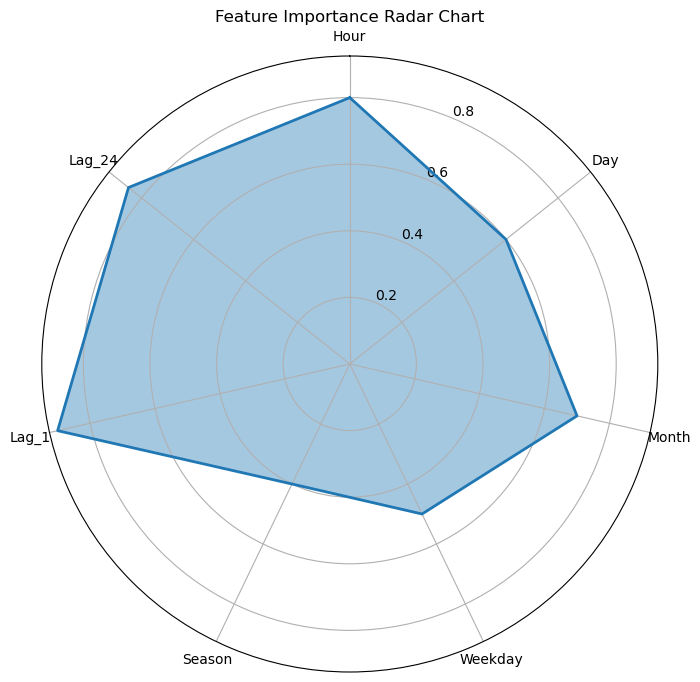

In [ ]:
from math import pi

features = ['Hour', 'Day', 'Month', 'Weekday', 'Season', 'Lag_1', 'Lag_24']
importance_values = [0.8, 0.6, 0.7, 0.5, 0.4, 0.9, 0.85]  # Replace with actual values

angles = [n / float(len(features)) * 2 * pi for n in range(len(features))]
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

importance_values += importance_values[:1]  # Complete loop
ax.plot(angles, importance_values, linewidth=2, linestyle='solid')
ax.fill(angles, importance_values, alpha=0.4)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)
plt.title("Feature Importance Radar Chart")
plt.show()

In [ ]:
model.save("lstm_model.h5")